In [1]:
import requests
from pathlib import Path
import pandas as pd
import seaborn as sns

This notebook is an implementation of the approach described in this [essay](https://www.orphanalytics.com/en/news/whitepaper202012/OrphAnalyticsQAnon2020.pdf) and written about [here](https://www.prnewswire.com/news-releases/qanon-is-two-different-people-shows-machine-learning-analysis-from-orphanalytics-301192981.html).

It analyzes the posts of QAnon, and concludes that the messages are probably written by two persons instead of one.

From the last link:
>  QAnon has spread conspiracy theories to an unprecedentedly large audience. Its thousands of online messages have popularized narratives such as the existence of a child-trafficking deep state. Recently, it inspired a series of violent attacks and was listed as a terrorist threat by the FBI. The Swiss company OrphAnalytics just published an analysis of all messages posted by Q. Its patented technology aims at identifying authors of written documents. It has found two individual signals within the corpus of Q messages. Its new study contributes to revealing the origins and the persons behind one of the most impactful conspiracy theories in recent times.

We will replicate their analysis with "patented technoloy" with a simple sklearn approach.

In [2]:
datadir = Path.home() / ".cache/mads_datasets/qanon"
if not datadir.exists():
    datadir.mkdir(parents=True)

datafile = datadir / "posts.json"
if not datafile.exists():
    url = "https://raw.githubusercontent.com/jkingsman/JSON-QAnon/main/posts.json"
    response = requests.get(url)
    with datafile.open("wb") as f:
        f.write(response.content)

In [6]:
from pandas import json_normalize
import json

with datafile.open(encoding='utf-8') as f:
    df = json_normalize(json.load(f)["posts"], sep="_")


In [7]:
df.dtypes

text                          object
referenced_posts              object
post_metadata_author          object
post_metadata_source_board    object
post_metadata_source_site     object
post_metadata_time             int64
post_metadata_id               int64
images                        object
post_metadata_tripcode        object
post_metadata_source_link     object
dtype: object

## Clean up the timestamps

The text describes they used the analysis from [this](https://www.businessinsider.com/every-qanon-message-q-drop-analyzed-2020-10?international=true&r=US&IR=T) businessinsider article to bin the timeseries.

<img src="../img/Qanon.png" width=450 height=400 />

These dates are hardcoded in the bin_time method.

In [8]:
df["time"] = df["post_metadata_time"].apply(pd.to_datetime, unit="s")

In [9]:
from datetime import datetime
def bin_time(time):
    if time < datetime(2017, 12, 1):
        return 0
    elif time < datetime(2018, 1, 1):
        return 1
    elif time < datetime(2018, 8, 10):
        return 2
    elif time < datetime(2019, 8, 1):
        return 3
    else:
        return 4

df["bintime"] = df["time"].apply(lambda x : bin_time(x))

Let's clean up the text some more. We will replace linebreaks ("\n") with spaces, remove urls and set everything to lowercase.

In [10]:
import re
def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text)

df["text"] = df["text"].apply(lambda x : str(x).replace("\n", " "))
df["text"] = df["text"].apply(lambda x : remove_url(x))
df["text"] = df["text"].apply(lambda x : x.lower())

Now, we count every text and filter chuncks with size below 50.

In [11]:
df['size'] = df['text'].apply(lambda x : len(str(x)))
df = df[df["size"] > 50]
df.reset_index(inplace=True, drop=True)

The paper describes batching all the text into chunks of 7500 characters. We can obtain sort of the same by splitting the text up into 100 batches, 7.7k each.

In [12]:
def batch_seq(text, k):
	longseq = " ".join(text)
	n = int(len(longseq) / k)
	parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
	return parts, n

z=100
parts, n = batch_seq(df["text"], k=z)
parts = parts[:-1]
len(parts), n

(100, 7734)

In [13]:
df.loc[:, 'group'] = df["size"].cumsum() // n

The paper uses a ngram with size 3 on characterlevel. We can do that with `CountVectorizer`

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3))
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

And calculates the pairwise manhattan distances. That way, we get an idea how how different every chunk is, when compared to all other chunks, in terms of the ngrams.

In [15]:
from sklearn.metrics.pairwise import manhattan_distances
distance = manhattan_distances(X, X)
distance.shape, type(distance)

((100, 100), numpy.ndarray)

To handle the labels, we make integers of the labels.

In [16]:
labels = df["post_metadata_source_site"].unique()
mapping = {labels[i]:i for i in range(3)}
df["source"] = df["post_metadata_source_site"].apply(lambda x : mapping[x])

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
model = pca.fit_transform(distance)

<Axes: xlabel='x', ylabel='y'>

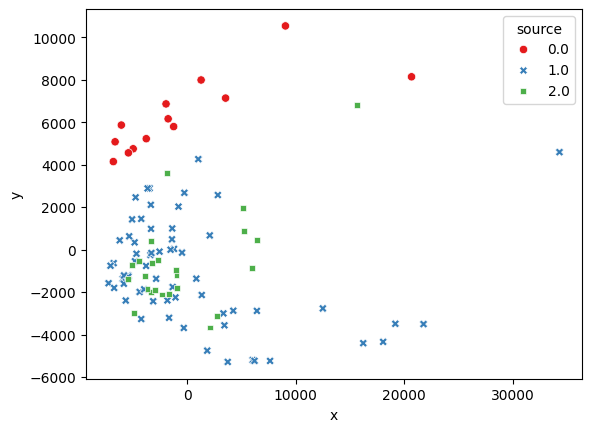

In [18]:
sourcemean = np.round(df.groupby("group").source.mean()).values.reshape(-1,1)
timemean = np.round(df.groupby("group").bintime.mean()).values.reshape(-1,1)
p = pd.DataFrame(np.concatenate([model, sourcemean, timemean], axis=1), columns=["x", "y", "source", "time"]).reset_index()
sns.scatterplot(data= p, x="x", y="y", hue="source", style="source", palette="Set1")

This reproduces the main conclusion, that the red source is not overlapping with the other two sources.

Of course, this tells you nothing about how high the chance is, that this is actually caused by having two authors, or by somehow changing the writing style.

For that, we would need access to how likely it is that the writing style changes this much.

However, we still have reproduced their "patented technology" with a few lines of code.
Let's wrap it into a class:

2024-03-19 20:10:36.699 | INFO     | src.model:batch_seq:26 - Splitting text into 100 parts of 7734 characters each
2024-03-19 20:10:36.707 | INFO     | src.model:batch_seq:29 - Removing 1 parts
2024-03-19 20:10:37.581 | INFO     | src.model:reduce_dims:41 - Using PCA


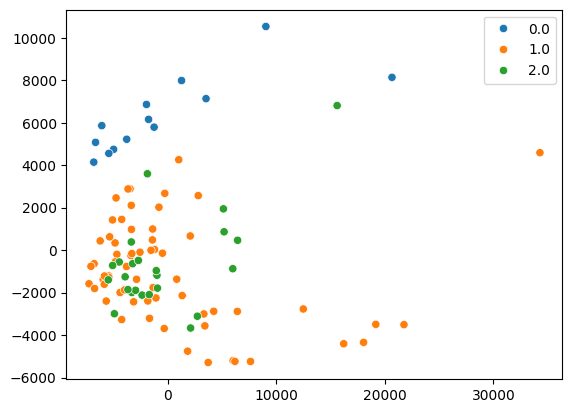

In [19]:
import sys
sys.path.insert(0, "..")

from src.model import TextClustering

clustering = TextClustering()
labels = sourcemean.flatten().astype(str)
clustering(text=df["text"], k=100, labels=labels, batch=True, method="PCA")

And now lets test it on the whatsapp data:

In [20]:
processed = Path("../data/processed")
datafile = processed / "whatsapp-20240122-182706.parq"
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")
wa_df = pd.read_parquet(datafile)
wa_df.head()

NameError: name 'logger' is not defined

We know the authors, so let's use the labels.

In [21]:
authors = list(np.unique(wa_df.author))

NameError: name 'wa_df' is not defined

We take a subset of every author, and join their texts.
Obviously, you can only do this if you know the authors, or at least the claimed authors. Concatenating all texts together will make the data useless. 

In [ ]:
n = 2000
min_parts = 2

corpus = {}
for author in authors:
	subset = wa_df[wa_df.author == author].reset_index()
	longseq = " ".join(subset.message)
	# chunk everything into n-sized parts
	parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
	# clean urls
	parts = [remove_url(chunk) for chunk in parts]
	# remove double spaces
	parts = [re.sub(' +', ' ', chunk) for chunk in parts]
	# keep only parts with more than min_parts
	if len(parts) > min_parts:
		corpus[author] = parts
corpus.keys()

In [ ]:
text = [part for text in corpus.values() for part in text]
wa_labels = [k for k,v in corpus.items() for _ in range(len(v))]
# we set batch to false, because we already batched the data
clustering(text=text, k=100, labels=wa_labels, batch=False, method="tSNE")